In [1]:
%matplotlib inline


/home/ubuntu/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [22]:
#path ="/home/ubuntu/nbs/data/dogscats/sample/"
path ="/home/ubuntu/nbs/data/dogscats/"


In [6]:
from __future__ import division,print_function

import os, json
from glob import glob
import numpy as np
np.set_printoptions(precision=4, linewidth=100)
from matplotlib import pyplot as plt

In [8]:
import utils; reload(utils)
from utils import plots

In [9]:
batch_size=64

In [10]:
# Import our class, and instantiate
import vgg16; reload(vgg16)
from vgg16 import Vgg16

In [11]:
vgg = Vgg16()
# Grab a few images at a time for training and validation.
# NB: They must be in subdirectories named based on their category
batches = vgg.get_batches(path+'train', batch_size=batch_size)
val_batches = vgg.get_batches(path+'valid', batch_size=batch_size*2)
vgg.finetune(batches)
vgg.fit(batches, val_batches, nb_epoch=1)

32768/35363 [==========================>...] - ETA: 0sFound 16 images belonging to 2 classes.
Found 8 images belonging to 2 classes.
Epoch 1/1
16/16 [==============================] - 1s - loss: 2.3484 - acc: 0.3750 - val_loss: 1.3892 - val_acc: 0.3750


In [12]:
vgg = Vgg16()

In [13]:
batches = vgg.get_batches(path+'train', batch_size=4)

Found 16 images belonging to 2 classes.


In [14]:
imgs,labels = next(batches)

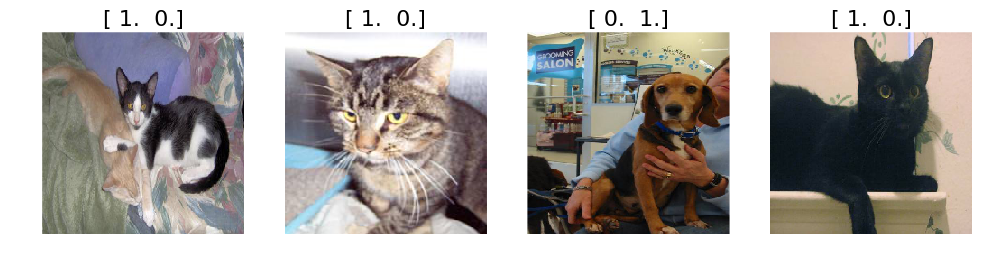

In [15]:
plots(imgs, titles=labels)

In [16]:
vgg.predict(imgs, True)

(array([ 0.2421,  0.7001,  0.2652,  0.2802], dtype=float32),
 array([158, 281, 237, 285]),
 [u'toy_terrier', u'tabby', u'miniature_pinscher', u'Egyptian_cat'])

In [17]:
vgg.classes[:4]

[u'tench', u'goldfish', u'great_white_shark', u'tiger_shark']

In [18]:
vgg.classes[:8]

[u'tench',
 u'goldfish',
 u'great_white_shark',
 u'tiger_shark',
 u'hammerhead',
 u'electric_ray',
 u'stingray',
 u'cock']

In [23]:
## in above path variable, change path to path ="/home/ubuntu/nbs/data/dogscats/" to pickup all images and execute 
## then run below steps
batch_size=64

In [24]:
batches = vgg.get_batches(path+'train', batch_size=batch_size)
val_batches = vgg.get_batches(path+'valid', batch_size=batch_size)

Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [25]:
vgg.finetune(batches)

In [26]:
vgg.fit(batches, val_batches, nb_epoch=1)

Epoch 1/1
23000/23000 [==============================] - 637s - loss: 0.1321 - acc: 0.9661 - val_loss: 0.0802 - val_acc: 0.9765


In [29]:
## Model setup


In [28]:
from numpy.random import random, permutation
from scipy import misc, ndimage
from scipy.ndimage.interpolation import zoom

import keras
from keras import backend as K
from keras.utils.data_utils import get_file
from keras.models import Sequential, Model
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.layers import Input
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import SGD, RMSprop
from keras.preprocessing import image

In [30]:
FILES_PATH = 'http://files.fast.ai/models/'; CLASS_FILE='imagenet_class_index.json'
# Keras' get_file() is a handy function that downloads files, and caches them for re-use later
fpath = get_file(CLASS_FILE, FILES_PATH+CLASS_FILE, cache_subdir='models')
with open(fpath) as f: class_dict = json.load(f)
# Convert dictionary with string indexes into an array
classes = [class_dict[str(i)][1] for i in range(len(class_dict))]

In [31]:
classes[:5]

[u'tench', u'goldfish', u'great_white_shark', u'tiger_shark', u'hammerhead']

In [33]:
def ConvBlock(layers, model, filters):
    for i in range(layers): 
        model.add(ZeroPadding2D((1,1)))
        model.add(Convolution2D(filters, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

In [34]:
def FCBlock(model):
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))

In [35]:
# Mean of each channel as provided by VGG researchers
vgg_mean = np.array([123.68, 116.779, 103.939]).reshape((3,1,1))

def vgg_preprocess(x):
    x = x - vgg_mean     # subtract mean
    return x[:, ::-1]    # reverse axis bgr->rgb

In [36]:
def VGG_16():
    model = Sequential()
    model.add(Lambda(vgg_preprocess, input_shape=(3,224,224)))

    ConvBlock(2, model, 64)
    ConvBlock(2, model, 128)
    ConvBlock(3, model, 256)
    ConvBlock(3, model, 512)
    ConvBlock(3, model, 512)

    model.add(Flatten())
    FCBlock(model)
    FCBlock(model)
    model.add(Dense(1000, activation='softmax'))
    return model

In [37]:
model = VGG_16()

In [38]:
fpath = get_file('vgg16.h5', FILES_PATH+'vgg16.h5', cache_subdir='models')
model.load_weights(fpath)

In [39]:
batch_size = 4

In [40]:
def get_batches(dirname, gen=image.ImageDataGenerator(), shuffle=True, 
                batch_size=batch_size, class_mode='categorical'):
    return gen.flow_from_directory(path+dirname, target_size=(224,224), 
                class_mode=class_mode, shuffle=shuffle, batch_size=batch_size)

Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


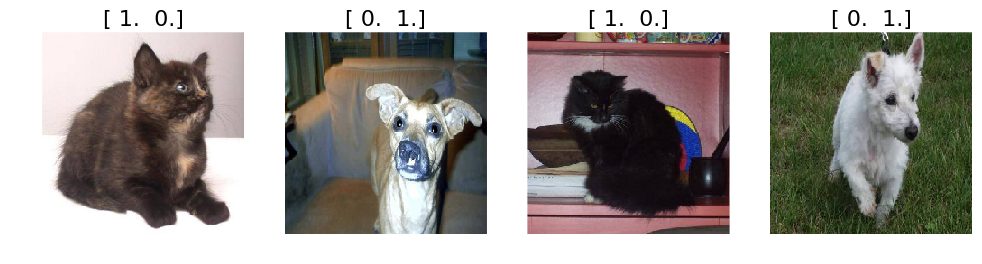

In [41]:
batches = get_batches('train', batch_size=batch_size)
val_batches = get_batches('valid', batch_size=batch_size)
imgs,labels = next(batches)

# This shows the 'ground truth'
plots(imgs, titles=labels)

In [42]:
def pred_batch(imgs):
    preds = model.predict(imgs)
    idxs = np.argmax(preds, axis=1)

    print('Shape: {}'.format(preds.shape))
    print('First 5 classes: {}'.format(classes[:5]))
    print('First 5 probabilities: {}\n'.format(preds[0, :5]))
    print('Predictions prob/class: ')
    
    for i in range(len(idxs)):
        idx = idxs[i]
        print ('  {:.4f}/{}'.format(preds[i, idx], classes[idx]))

In [43]:
pred_batch(imgs)

Shape: (4, 1000)
First 5 classes: [u'tench', u'goldfish', u'great_white_shark', u'tiger_shark', u'hammerhead']
First 5 probabilities: [  2.3448e-07   6.3789e-06   1.2781e-06   9.4720e-07   7.5491e-07]

Predictions prob/class: 
  0.1544/Persian_cat
  0.6847/whippet
  0.1287/desk
  0.4857/West_Highland_white_terrier
